<a href="https://colab.research.google.com/github/N-Alotaibi/NA/blob/master/POA_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Irradiance Transposition

A notebook to compute plane-of-array irradiance over varying time integrations using irradiance data from the Sheffield Solar testbed.

*Jamie Taylor, A Buckley*

*First Authored: 2019-11-05*

*Revised: 2020-08-28*


---



## Setup
Install the necessary Python packages:

In [ ]:
!pip install numpy pandas>1.0 matplotlib pvlib

Import some modules:

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import pvlib
import matplotlib.pyplot as plt

Change this setting to make plots bigger or smaller:

In [ ]:
plt.rcParams['figure.dpi'] = 120

Hard code some inputs as variables (don't do this in production code!):

In [ ]:
lat = 53.23
lon = -1.15
ori = 225
tilt = 35

## Functions

A function to load the testbed data:

In [ ]:
def load_testbed_data():
    """
    Load pyranometer data from a CSV file. This data file includes measured GHI and horizontal
    diffuse radiation.
    """
    url = "https://raw.githubusercontent.com/alastairbuckley/PHY6000/master/ss_testbed_irrad_2012.csv"
    data = pd.read_csv(url, parse_dates=["dateandtime"])
    # Use the col_mapper dictionary to rename cols
    col_mapper = {"dateandtime": "timestamp", "GHI": "ghi", "DHI": "dhi"}
    data.rename(columns=col_mapper, inplace=True)
    # Set the timestamp as the index of the dataframe
    data.set_index("timestamp", inplace=True)
    # Tell pandas our timestamps are UTC
    data = data.tz_localize(tz="UTC")
    return data

A function to simulate Extra-atmospheric irradiance:

In [ ]:
def simulate_eai(start, end, lat, lon, freq="1min"):
    """Simulate EAI for a given time range, location and frequency."""
    # Create a DatetimeIndex of minutely timestamps
    times = pd.date_range(start=start, end=end, freq=freq, tz="UTC")
    # Create a Location object
    loc = pvlib.location.Location(lat, lon, tz="UTC", altitude=130, name="Hicks Bulding Lower Roof")
    # Compute the solar position for the times
    solpos = loc.get_solarposition(times)
    # Simulate EAI for the times (not corrected for location)
    eai_global = pvlib.irradiance.get_extra_radiation(times)
    # Correct for location
    eai = eai_global * np.cos(np.radians(solpos["apparent_zenith"]))
    eai[eai < 0] = 0
    # Convert EAI to a Dataframe with named column (helpful later)
    eai = pd.DataFrame(eai, columns=["eai"])
    eai_global = pd.DataFrame(eai_global, columns=["eai_global"])
    eai = eai.merge(eai_global, left_index=True, right_index=True)
    return eai, solpos

Functions to produce our plots later:


In [ ]:
def plot_irradiance_timeseries(irr, inplane):
    """Plot GTI and GHI time series."""
    # Create a new figure
    fig = plt.figure()
    # Add title
    fig.suptitle("GTI vs GHI")
    # Plot GHI
    ax = irr["ghi"].plot(label="GHI", linewidth=1)
    # Plot GTI
    inplane["poa_global"].plot(ax=ax, label="GTI", linewidth=1)
    # Label the axes
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Irradiance (W/m^2)')
    # Show legend entries
    ax.legend()
    plt.show()

def plot_kd(erbs, irr):
    """Create a new figure to plot actual and modelled kd."""
    fig = plt.figure()
    ax = fig.add_subplot()
    # Add title
    fig.suptitle("Modelled vs actual diffuse fraction")
    ## Plot kd_erbs vs kd
    actual_kd = irr["dhi"] / irr["ghi"]
    modelled_kd = erbs["dhi"] / irr["ghi"]
    plt.scatter(actual_kd, modelled_kd, edgecolor=None, alpha=0.3)
    # Label the axes
    ax.set_xlabel('Actual kd')
    ax.set_ylabel('Modelled kd')
    plt.show()

def plot_gti_vs_ghi(irr, inplane):
    """Plot GTI vs GHI."""
    # Create a new figure
    fig = plt.figure()
    ax = fig.add_subplot()
    # Add title
    fig.suptitle("GTI vs GHI")
    # Plot
    plt.scatter(irr["ghi"], inplane["poa_global"], edgecolor=None, alpha=0.3)
    ax.set_xlabel('GHI (W/m2)')
    ax.set_ylabel('GTI (W/m2)')
    plt.show()

## Bring it all together...

In [ ]:
# Load the pyranometer data from CSV
irr = load_testbed_data()

# Determine the start/end date based on the pyran data just loaded
start = irr.index[0]
end = irr.index[-1]

# Simulate the minutely EAI for the same period
eai, solpos = simulate_eai(start, end, lat, lon)

# Merge the irr, eai and solpos df's so only indices in both are kept
irr_ = irr.merge(solpos, left_index=True, right_index=True).merge(eai, left_index=True,
                                                                  right_index=True)

# Use the Erbs model to estimate diffuse fraction
erbs = pvlib.irradiance.erbs(irr_["ghi"], irr_["zenith"], irr_.index)

# Transpose to the inclined plane
inplane = pvlib.irradiance.get_total_irradiance(tilt, ori, irr_["zenith"], irr_["azimuth"],
                                                erbs["dni"], irr_["ghi"], erbs["dhi"],
                                                irr_["eai_global"], surface_type="urban",
                                                model="haydavies")

## Plot our results

Minutely irradiance time-series:

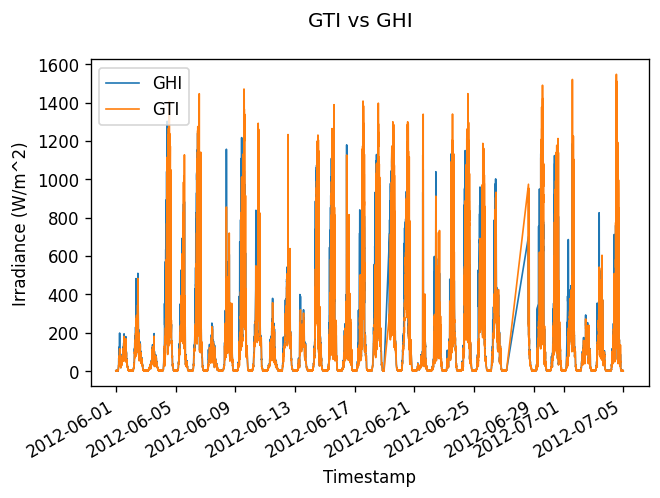

In [ ]:
plot_irradiance_timeseries(irr_.loc["2012-06-01":"2012-07-04"], inplane.loc["2012-06-01":"2012-07-04"])



---


Minutely diffuse fraction (kd), modelled vs actual:

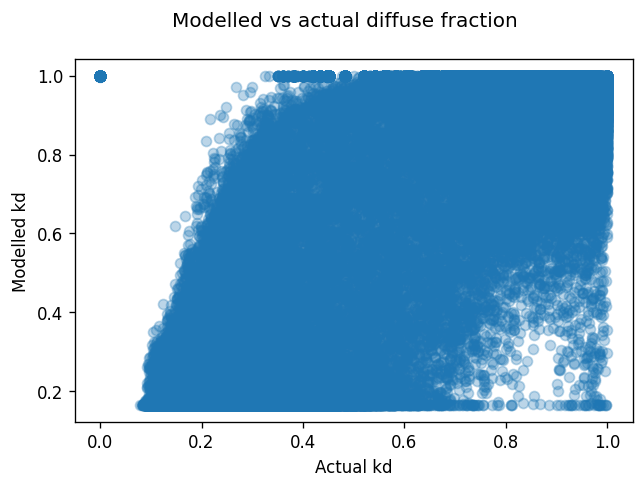

In [ ]:
plot_kd(erbs, irr_)



---


Minutely Global Tilted Irradiance (GTI) vs Global Horizontal Irradiance (GHI):

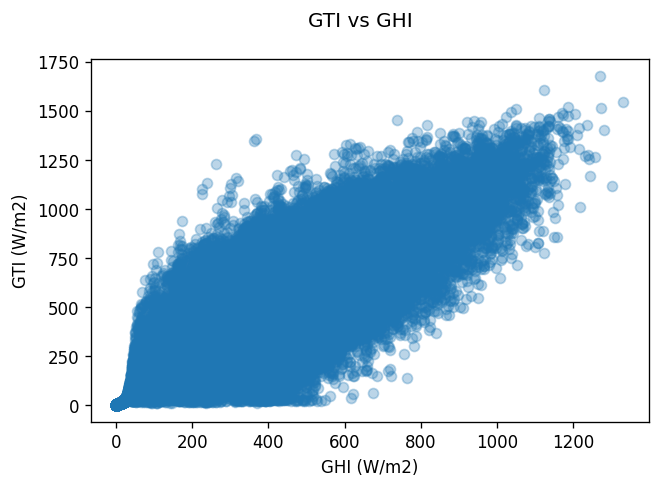

In [ ]:
plot_gti_vs_ghi(irr_, inplane)